In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Chapter2 モンテカルロ法

ある確率分布$\pi(x)$に従う乱数 $x$ を発生させることを考える。

## 逆変換法

連続型確率変数$x$の分布関数を
$$F(z) = \int^z_{-\infty}\pi(x)dx$$
と表すとする。
### アルゴリズム

1. 一様分布$U(0,1)$から$u$を発生させる。
2. $x=F^{-1}(x)$を返す。  

### 例 :指数分布
$$\pi(x;\theta)  = \begin{cases}\theta e^{-\theta{x}} ~&(x\geq 0)\\ 0 ~&(x < 0)\end{cases}$$
分布関数は $F(z) = 1-e^{-\theta z}$ である. 逆関数は$F^{-1}(u) = -\frac{1}{\theta}\log(1-u)$なのでここからサンプルする.

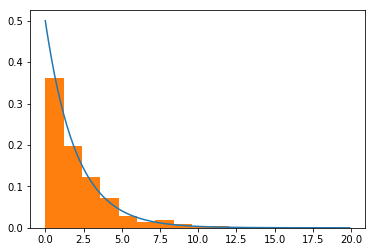

In [3]:
n = 1000 # number of sampling

# sampling from exponential distribution
def sampling_from_exp(theta, n):
    inv_F = lambda u: -1/theta * np.log(1-u) # inverse of distribution function F(z)
    return inv_F(np.random.rand(n))

theta = 0.5
pi = lambda x: theta * np.exp(-theta * x) if x >= 0 else 0  # target : probability densty function (PDF)
sampled_x = sampling_from_exp(theta, n)

plt.plot(np.arange(0,20,0.1), [pi(x) for x in np.arange(0,20,0.1)]) # plot PDF
plt.hist(sampled_x, normed=True)
plt.show()

## 棄却法
### アルゴリズム
1. $q(y)$から$y$をサンプル
2. $U(0,1)$から$u$をサンプル
3. $u\leq \pi(y)/Cq(y)$ であれば受容し$x=y$としてサンプル。そうでなければ$y$を棄却して1へ

### 例 : 切断正規分布
$$\pi(x) = \frac{2}{\sqrt{2\pi}}e^{-x^2/2} ~~(x \geq 0)$$
$q(x)$には$e^{-x}$を採用するとしよう（上の逆変換法でサンプリングを実装済）。すると少し計算すると$C=\sqrt{2e/pi}$を選ぶと一番ぴったりで、$q(x)$で$\pi(x)$を覆うことができる。これを使ってサンプリングする。

棄却率 : 0.22999999999999998


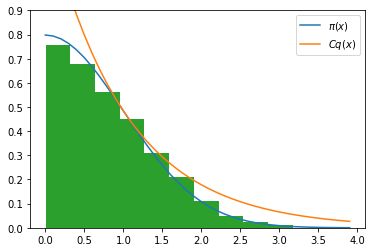

In [4]:
pi = lambda x: 2/np.sqrt(2*np.pi)*np.exp(-x**2/2)
q = lambda x: np.exp(-x)

C = np.sqrt(2*np.e / np.pi)
def refection_sampling_truncated_gaussian(n):
    y = sampling_from_exp(theta=1, n=n)
    u = np.random.rand(n)
    return y[u <= pi(y)/(C*q(y))]

xlist = np.arange(0,4,0.1)
plt.plot(xlist, pi(xlist), label='$\pi(x)$')
plt.plot(xlist, C*q(xlist), label='$Cq(x)$')
sample_data = refection_sampling_truncated_gaussian(n)
plt.hist(sample_data, normed=True)
plt.ylim(0,0.9)
plt.legend()
print('棄却率 : {}'.format(1-len(sample_data)/n))

## 適応的棄却法
$h(x) := \log \pi(x)$, $h(x)$は凸関数であるとする。
### アルゴリズム
1. $q_m(y)$ から $y$をサンプリング
2. $U(0,1)$ から u をサンプリング
3. $u \leq \exp(h(y) - u_m(y))$なら $x=y$ として受容。そうでなければ、$S_m$に$y$を加えて $u_m(x)$と$q_m(x)$を更新し、$y$を棄却して1に戻る。

In [30]:
class Lines:
    def __init__(self, dudx, x, h):
        self.dudx = dudx
        self.x = x
        self.h = h

    def __call__(self, x):
        return self.dudx*(x-self.x) + self.h

class AdaptiveRejectionSampling:
    def __init__(self, pi, xrange, x_init):
        self.x = np.array(x_init)
        self.xrange = xrange
        self.pi = pi
        
        self.update()
        
    def update(self):
        self.h = np.log(self.pi(self.x))
        self.dudx = np.diff(self.h)/np.diff(self.x)
        
        # 各直線
        self.L = [Lines(self.dudx[i], self.x[i], self.h[i]) for i in range(len(self.x)-1)]
        # 折れ曲がった中点
        dudx_ip1 = self.dudx[2:]
        dudx_im1 = self.dudx[:-2]
        x_ip1 = self.x[2:-1]
        x_im1 = self.x[:-3]
        self.mid_x = (dudx_ip1*x_ip1 - dudx_im1*x_im1 - self.h[2:-1] + self.h[:-3])/(dudx_ip1-dudx_im1)
        
        # 折れ曲がった直線の順番
        self.um_L = np.array(self.L[:2])
        self.um_L = np.hstack([self.um_L, np.array([[self.L[i], self.L[i+2]] \
                                            for i in range(len(self.L)-2)]).flatten()])
        self.um_L = np.hstack([self.um_L, self.L[-2:]])
        
        self.Fu = self.dist_func_u()
        
    def sampling(self, n):
        y_list = []
        for _ in range(n):
            y = self.upper_sampling()
            u = np.random.rand()
            if u <= self.pi(y)/np.exp(self.u_m(y)):
                y_list.append(y)
            else:
                self.x = np.sort(np.hstack([self.x, y]))
                self.update()
        return y_list
    
    def u_m(self, x):
        if x <= self.x[0]:    return self.L[0](x)
        elif x >= self.x[-1]: return self.L[-1](x)
        elif x <= self.x[1]:  return self.L[1](x)
        elif x >= self.x[-2]: return self.L[-2](x)
        else:
            i = len(self.x[self.x < x]) - 1
            return min(self.L[i-1](x), self.L[i+1](x))
        
    def upper_sampling(self):
        u = np.random.rand()
        i = len(self.Fu[self.Fu/self.Fu[-1] < u]) - 1
        xt = self.um_L[i].x + (-self.um_L[i].h + np.log(self.um_L[i].dudx*(self.Fu[-1]*u - self.Fu[i]) \
        + self.exp_um[i])) / self.um_L[i].dudx
        return xt
        
    def dist_func_u(self):
        # 折れ曲がった中点も含めたxの集合
        self.mid_x_list = np.sort(np.hstack([self.x, self.mid_x]))
        um = np.array([self.u_m(x) for x in self.mid_x_list])
        um[0] = self.L[1](self.mid_x_list[0])
        um[-1] = self.L[-2](self.mid_x_list[-1])
        
        # umの直線に対応したdudxを構成
        self.new_dudx = [l.dudx for l in self.um_L]
         
        # umの積分
        if self.xrange[0] is not None:
            Fu_i = 1/self.dudx[0]*(np.exp(self.h[0]) - np.exp(self.L[0](self.xrange[0])))
            self.exp_um = np.hstack([np.exp(self.u_m(self.xrange[0])),np.exp(um)])
        else:
            Fu_i = 1/self.dudx[0]*np.exp(self.h[0])
            self.exp_um = np.hstack([0,np.exp(um)])
        Fu = np.hstack([0, Fu_i, Fu_i + np.cumsum(np.diff(np.exp(um))/self.new_dudx[1:-1])])
        if self.xrange[1] is not None:
            Fu_f = -1/self.dudx[-1]*(np.exp(self.h[-1])-np.exp(self.L[-1](self.xrange[1])))
        else:
            Fu_f = -1/self.dudx[-1]*np.exp(self.h[-1])
        Fu = np.hstack([Fu, Fu[-1]+Fu_f])
        return Fu

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


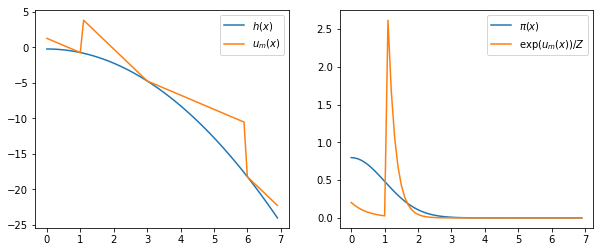

In [38]:
# 確率密度関数
pi = lambda x: 2/np.sqrt(2*np.pi)*np.exp(-x**2/2)
ars = AdaptiveRejectionSampling(pi, xrange=(0, None), x_init=[1,3,6])
xlist = np.arange(0,7,0.1)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(xlist, np.log(pi(xlist)), label="$h(x)$")
axL.plot(xlist, [ars.u_m(x) for x in xlist], label="$u_m(x)$")
axL.legend()

axR.plot(xlist, pi(xlist), label="$\pi(x)$")
Z = ars.dist_func_u()[-1]
axR.plot(xlist, np.exp([ars.u_m(x) for x in xlist])/Z, label="$\exp(u_m(x))/Z$")
axR.legend()

fig.show()

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


棄却率 : 0.015000000000000013


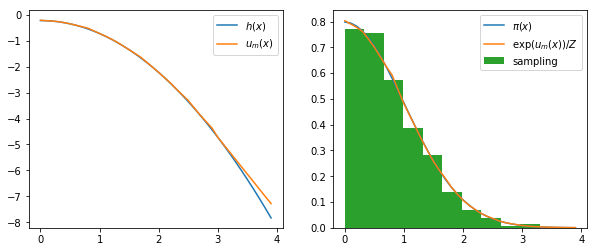

In [39]:
sample_data = ars.sampling(n=n)
xlist = np.arange(0,4,0.1)

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.plot(xlist, np.log(pi(xlist)), label="$h(x)$")
axL.plot(xlist, [ars.u_m(x) for x in xlist], label="$u_m(x)$")
axL.legend()

axR.plot(xlist, pi(xlist), label="$\pi(x)$")
Z = ars.dist_func_u()[-1]
axR.plot(xlist, np.exp([ars.u_m(x) for x in xlist])/Z, label="$\exp(u_m(x))/Z$")
axR.hist(sample_data, normed=True, label="sampling")
axR.legend()

fig.show()
print('棄却率 : {}'.format(1-len(sample_data)/n))

## 混合法（連続変数）
PDFが以下のように書けて、各重み$w$と条件付き確率$p(x|y)$からサンプルできるときに使える。
$$\pi(x) = \int_0^\infty p(x|y)w(y)dy$$
### アルゴリズム
1. $w(y)$から$y$をサンプリング
2. $p(x|y)$から$x$をサンプリング

### t分布
$$f(t)=\frac{\Gamma((\nu + 1)/2)}{\sqrt{\nu \pi}\Gamma(\nu/2)}(1+t^2/\nu)^{-(\nu+1)/2}$$

In [85]:
nu = 10
n=100000
# 1.
y = np.random.gamma(nu/2,nu/2,n)
# 2.
x = np.random.normal(0,1/y, n)

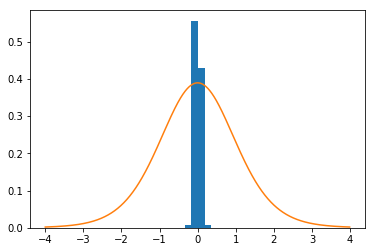

In [86]:
from scipy.special import gamma
f = lambda t : gamma((nu+1)/2)/(np.sqrt(nu*np.pi)*gamma(nu/2))*(1+t**2/nu)**(-(nu+1)/2)
tlist = np.arange(-4,4,0.01)
weights = np.ones(len(x))/float(len(x))
plt.hist(x, weights=weights)
plt.plot(tlist, f(tlist))